# ENMAP Query

Below is an example for NZ.

I cannot seem to query the stc catalog for cloud, so i post filter.


In [32]:
from pystac_client import Client
import json

# This is the URL for the EOC Geoservice STAC catalogue
catalog = Client.open("https://geoservice.dlr.de/eoc/ogc/stac/v1/")

# Collections to be searched
collections = ["ENMAP_HSI_L2A"]

# Set bounding box [west, south, east, north]
# NZ
bbox = [166, -48, 179, -33]

# Set the cloud threshold
cloud_cover_max = 10

# Perform the search
search = catalog.search(
    collections=collections,
    bbox=bbox
)

matched = search.matched()
print(f"{matched} files found")

# Retrieve items using the generator for efficient paging
items = search.items()

# Initialize the FeatureCollection structure
feature_collection = {
    "type": "FeatureCollection",
    "features": []
}

download_links = []

for item in items:
    item_id = item.id
    cloud_cover = float(item.properties.get("eo:cloud_cover", 100))  # Default to 100 if not available
    item_datetime = item.properties.get("datetime", "")
    geometry = item.geometry
    biome_type = item.properties.get("enmap:biomeType", 'not available')
    
    # Retrieve asset URLs with safety checks
    image = item.assets.get("image", {}).href if "image" in item.assets else None
    thumbnail = item.assets.get("thumbnail", {}).href if "thumbnail" in item.assets else None

    if cloud_cover < cloud_cover_max and biome_type != 'not available':
        # Construct a GeoJSON Feature
        feature = {
            "type": "Feature",
            "geometry": geometry,
            "properties": {
                "id": item_id,
                "cloud": cloud_cover,
                "datetime": item_datetime,
                "biome": biome_type,
                "image": image,
                "thumbnail": thumbnail
            }
        }
        feature_collection["features"].append(feature)
        if image:
            download_links.append(image)

# Define the output GeoJSON file path
output_geojson = "enmap_query.geojson"

# Write the FeatureCollection to a GeoJSON file with indentation for readability
with open(output_geojson, 'w') as f:
    json.dump(feature_collection, f, indent=2)

# Save the download links to a text file
with open("enmap_download_links.txt", 'w') as f:
    for link in download_links:
        f.write(link + '\n')

print(f"GeoJSON FeatureCollection written to {output_geojson}")
print(f"Download links written to enmap_download_links.txt")

1215 files found
GeoJSON FeatureCollection written to enmap_query.geojson
Download links written to enmap_download_links.txt


# Intersect EMIT and ENMAP data
This takes a couple of hours to find all the overlapping images.


It initially queries the EMIT STAC, then for each EMIT image it queries the ENMAP STAC to find overlapping images.


It finds 3247 EMIT items with cloud less than 3% and 818 pairs within 3 days of an ENMAP image.

In [5]:
from pystac_client import Client
from datetime import datetime, timedelta
import joblib

def emit_stac(bbox, datetime_bounds=None):
    """
    Query the STAC catalog with the specified bounding box and return matching items.

    :param bbox: Tuple of (swLon, swLat, neLon, neLat) defining the bounding box.
    :return: List of items returned by the query.
    """
    # Define the catalog
    # LPCLOUD catalog URL
    catalog_url = 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/'
    catalog = Client.open(catalog_url)

    # Define search parameters with the passed bounding box
    search_params = {
        "collections": ["EMITL2ARFL_001"],  # Specify the collection
        "bbox": bbox,                       # Use the provided bounding box
        "query": {
            "eo:cloud_cover": {"lt": 3}   # Query parameter: cloud cover less than 2%
        }
    }

    # Run the STAC query
    query = catalog.search(**search_params)

    # List items returned by the query
    items = list(query.items())
    return items



def enmap_stac(bbox, datetime_bounds=None):
    """
    Query the STAC catalog with the specified bounding box and return matching items.

    :param bbox: List of [swLon, swLat, neLon, neLat] defining the bounding box.
    :return: ItemCollection returned by the query.
    """
    # Open the catalog
    catalog_url = "https://geoservice.dlr.de/eoc/ogc/stac/v1/"
    catalog = Client.open(catalog_url)

    # Collections to be searched
    collections = ["ENMAP_HSI_L2A"]

    # Perform the search
    search = catalog.search(
        collections=collections,
        bbox=bbox,
        datetime=datetime_bounds
    )

    # Return the items collection
    items = search.item_collection()
    return items

# Australia BBOX
bounding_box = [112,-44, 154,-9]
bounding_box = [112,-7, 179,-9]

emit_items = emit_stac(bounding_box)

print(f"Found {len(emit_items)} EMIT items.")
datetime_buffer_days = 3
matched_items = []

for item in emit_items:
    print('.', end='')
    item_bbox = item.bbox
    # Build a STAC query for the ENMAP catalog
    start_datetime = item.datetime - timedelta(days=datetime_buffer_days)
    end_datetime = item.datetime + timedelta(days=datetime_buffer_days)
    stack_datetime = f"{start_datetime.strftime('%Y-%m-%dT%H:%M:%S')}Z/{end_datetime.strftime('%Y-%m-%dT%H:%M:%S')}Z"
    enmap_items = enmap_stac(item_bbox, datetime_bounds=stack_datetime)
    if len(enmap_items) > 0:
        for enmap_item in enmap_items:
            cloud_cover = float(enmap_item.properties["eo:cloud_cover"])
            if cloud_cover < 3: # Can't seem to query their stack for cloud cover
                # Add the two items to the matched_items
                matched_items.append((item, enmap_item))           
                print(f"\nEnmap ID: {enmap_item.id}, EMIT ID: {item.id}, Date: {item.datetime}")
    
# Save the matched items to a pickle file
joblib.dump(matched_items, 'matched_items.pkl')






APIError: {"errors":["Oops! A problem occurred upstream and we were unable to process your request. We have been alerted and are working to resolve the problem. Please try your request again later."]}

### Graph of the matched pairs

818


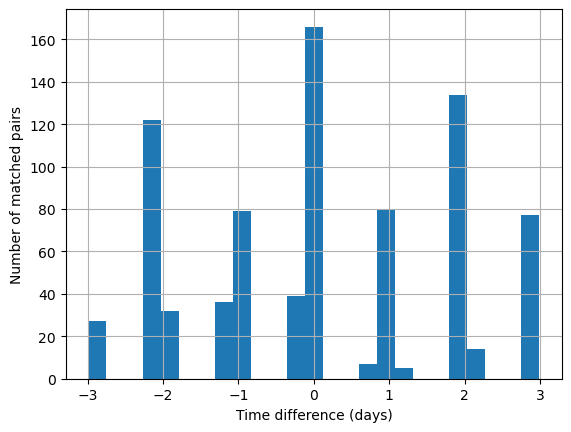

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import joblib


# Load the matched items from the pickle file
matched_items = joblib.load('matched_items.pkl')


def parse_datetime(datetime_str):
    # Try to parse datetime with and without microseconds
    try:
        return datetime.strptime(datetime_str, "%Y-%m-%dT%H:%M:%S.%fZ")
    except ValueError:
        return datetime.strptime(datetime_str, "%Y-%m-%dT%H:%M:%SZ")

# Make a list of the time difference between the two acquisitions
time_differences = []

for item in matched_items:
    try:
        enmap_time_str = item[1].properties["datetime"]
        emit_time_str = item[0].properties["datetime"]

        enmap_datetime = parse_datetime(enmap_time_str)
        emit_datetime = parse_datetime(emit_time_str)

        time_difference = enmap_datetime - emit_datetime
        time_differences.append(time_difference.total_seconds() / 60 / 60 / 24)  # Convert to hours
    except ValueError as e:
        print(f"Failed to parse datetime format for enmap: {enmap_time_str} or emit: {emit_time_str}")
        continue

# Plot a histogram of the time differences


plt.hist(time_differences, bins=25)
plt.xlabel("Time difference (days)")
plt.ylabel("Number of matched pairs")
plt.grid()


## Find the unique ids of the cloud free same day matches

Find the unique ids of the cloud free same day matches

In [11]:
from datetime import datetime
import json
from shapely.geometry import shape
import os

# Specify a directory to save the downloaded files
SAVE_DIRECTORY = "/mnt/e/Temp/aus_matched"


def parse_datetime(datetime_str):
    # Try to parse datetime with and without microseconds
    try:
        return datetime.strptime(datetime_str, "%Y-%m-%dT%H:%M:%S.%fZ")
    except ValueError:
        return datetime.strptime(datetime_str, "%Y-%m-%dT%H:%M:%SZ")

def get_emit_assets(item):
    item_assets = item.assets
    asset_keys = list(item_assets.keys())
    # Collect the href links for assets with '001/' in the keys
    emit_assets = [item_assets[key].href for key in asset_keys if '001/' in key]
    return emit_assets

def create_geojson_feature_collection(matched_items):
    features = []

    for item in matched_items:
        emit_id = item[0].id
        enmap_id = item[1].id
        emit_datetime = parse_datetime(item[0].properties["datetime"]).strftime("%Y-%m-%d %H:%M:%S")
        enmap_datetime = parse_datetime(item[1].properties["datetime"]).strftime("%Y-%m-%d %H:%M:%S")
        emit_cloud_cover = float(item[0].properties["eo:cloud_cover"])
        enmap_cloud_cover = float(item[1].properties["eo:cloud_cover"])

        emit_geometry = item[0].geometry
        enmap_geometry = item[1].geometry
        
        emit_feature = {
            "type": "Feature",
            "geometry": emit_geometry,
            "properties": {
                "id": emit_id,
                "datetime": emit_datetime,
                "cloud_cover": emit_cloud_cover,
                "type": "emit"
            }
        }
        
        enmap_feature = {
            "type": "Feature",
            "geometry": enmap_geometry,
            "properties": {
                "id": enmap_id,
                "datetime": enmap_datetime,
                "cloud_cover": enmap_cloud_cover,
                "type": "enmap"
            }
        }

        features.append(emit_feature)
        features.append(enmap_feature)

    feature_collection = {
        "type": "FeatureCollection",
        "features": features
    }

    return feature_collection

# Main code execution
cloud_threshold = 10
days_threshold = 0.14
filtered_items = []  # List to store items meeting all criteria
enmap_urls = []
emit_urls = []

for item in matched_items:
    enmap_cloud_cover = float(item[1].properties["eo:cloud_cover"])
    emit_cloud_cover = float(item[0].properties["eo:cloud_cover"])
    
    if enmap_cloud_cover > cloud_threshold or emit_cloud_cover > cloud_threshold:
        continue
    
    enmap_datetime = parse_datetime(item[1].properties["datetime"])
    emit_datetime = parse_datetime(item[0].properties["datetime"])
    time_difference = abs((enmap_datetime - emit_datetime).total_seconds() / 60 / 60 / 24)  # Convert to days
    
    if time_difference > days_threshold:
        continue

    enmap_polygon = shape(item[1].geometry)
    emit_polygon = shape(item[0].geometry)
    if not enmap_polygon.intersects(emit_polygon):
        continue

    
    filtered_items.append(item)
    enmap_urls.append(item[1].assets["image"].href)
    emit_urls.extend(get_emit_assets(item[0]))

geojson_feature_collection = create_geojson_feature_collection(filtered_items)

# Get the unique URLs
emit_urls = list(set(emit_urls))
enmap_urls = list(set(enmap_urls))

# Print results
print(f"Found {len(enmap_urls)} unique Enmap IDs and {len(emit_urls)} unique EMIT IDs.")
print(f"Created GeoJSON FeatureCollection with {len(geojson_feature_collection['features'])} features.")

with open(os.path.join(SAVE_DIRECTORY,'matched_features.geojson'), 'w') as f:
    json.dump(geojson_feature_collection, f, indent=2)

# Save the unique URLs to a text file
with open(os.path.join(SAVE_DIRECTORY,'enmap_urls.txt'), 'w') as f:
    for url in enmap_urls:
        f.write(f"{url}\n")

with open(os.path.join(SAVE_DIRECTORY,'emit_urls.txt'), 'w') as f:
    for url in emit_urls:
        f.write(f"{url}\n")
    


Found 91 unique Enmap IDs and 129 unique EMIT IDs.
Created GeoJSON FeatureCollection with 264 features.


In [1]:
from pystac_client import Client
from datetime import datetime, timedelta

def emit_stac(bbox):
    """
    Query the STAC catalog with the specified bounding box and return items from the last week.

    :param bbox: Tuple of (swLon, swLat, neLon, neLat) defining the bounding box.
    :return: List of items returned by the query.
    """
    # Define the catalog
    # LPCLOUD catalog URL
    catalog_url = 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/'
    catalog = Client.open(catalog_url)

    # Calculate the date range for the last week
    end_date = datetime.utcnow()
    start_date = end_date - timedelta(days=7)
    datetime_bounds = f"{start_date.strftime('%Y-%m-%dT%H:%M:%S')}Z/{end_date.strftime('%Y-%m-%dT%H:%M:%S')}Z"
    # Define search parameters with the passed bounding box and datetime bounds
    search_params = {
        "collections": ["EMITL2ARFL_001"],  # Specify the collection
        "bbox": bbox,                       # Use the provided bounding box
        "datetime": datetime_bounds         # Use the calculated datetime bounds
    }

    # Run the STAC query
    query = catalog.search(**search_params)

    # List items returned by the query
    items = list(query.items())
    # Remove items with cloud cover > 50%
    items = [item for item in items if float(item.properties.get("eo:cloud_cover", 100)) <= 50]

    return items


def enmap_stac(bbox):
    """
    Query the STAC catalog with the specified bounding box and return items from the last week.

    :param bbox: List of [swLon, swLat, neLon, neLat] defining the bounding box.
    :return: ItemCollection returned by the query.
    """
    # Open the catalog
    catalog_url = "https://geoservice.dlr.de/eoc/ogc/stac/v1/"
    catalog = Client.open(catalog_url)

    # Calculate the date range for the last week
    end_date = datetime.utcnow()
    start_date = end_date - timedelta(days=7)
    datetime_bounds = f"{start_date.strftime('%Y-%m-%dT%H:%M:%S')}Z/{end_date.strftime('%Y-%m-%dT%H:%M:%S')}Z"
    # Collections to be searched
    collections = ["ENMAP_HSI_L2A"]

    # Perform the search
    search = catalog.search(
        collections=collections,
        bbox=bbox,
        datetime=datetime_bounds
    )

    # Return the items collection
    items = search.item_collection()
    # Remove items with cloud cover > 50%
    items = [item for item in items if float(item.properties.get("eo:cloud_cover", 100)) <= 50]
    return items

# Australia BBOX
bounding_box = [112,-44, 154,-9]
# Field BBOX
bounding_box = [140,-34, 151,-25]

emit_items = emit_stac(bounding_box)
enmap_items = enmap_stac(bounding_box)

print(f"Found {len(emit_items)} EMIT items from the last week.")
print(f"Found {len(enmap_items)} ENMAP items from the last week.")


Found 0 EMIT items from the last week.
Found 21 ENMAP items from the last week.


In [ ]:
from dateutil.parser import parse as parse_datetime
import json

def stac_items_to_geojson(stac_items):
    """
    Convert a list of STAC items to a GeoJSON FeatureCollection.

    :param stac_items: List of STAC items.
    :return: Dictionary representing the GeoJSON FeatureCollection.
    """
    features = []

    for item in stac_items:
        item_id = item.id
        item_datetime = parse_datetime(item.properties["datetime"]).strftime("%Y-%m-%d %H:%M:%S")
        cloud_cover = float(item.properties.get("eo:cloud_cover", 0))
        geometry = item.geometry
        

        feature = {
            "type": "Feature",
            "geometry": geometry,
            "properties": {
                "id": item_id,
                "datetime": item_datetime,
                "cloud_cover": cloud_cover
            }
        }

        features.append(feature)

    feature_collection = {
        "type": "FeatureCollection",
        "features": features
    }

    return feature_collection

geojson = stac_items_to_geojson(enmap_items)
# Save the GeoJSON to a file
with open('enmap_items.geojson', 'w') as f:
    json.dump(geojson, f, indent=2)

# Odienne

In [8]:
from pystac_client import Client
from datetime import datetime, timedelta

def emit_stac(bbox):
    """
    Query the STAC catalog with the specified bounding box and return items from the last week.

    :param bbox: Tuple of (swLon, swLat, neLon, neLat) defining the bounding box.
    :return: List of items returned by the query.
    """
    # Define the catalog
    # LPCLOUD catalog URL
    catalog_url = 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/'
    catalog = Client.open(catalog_url)

    # Calculate the date range for the last week
    end_date = datetime.utcnow()
    start_date = end_date - timedelta(weeks=1000)
    datetime_bounds = f"{start_date.strftime('%Y-%m-%dT%H:%M:%S')}Z/{end_date.strftime('%Y-%m-%dT%H:%M:%S')}Z"
    # Define search parameters with the passed bounding box and datetime bounds
    search_params = {
        "collections": ["EMITL2ARFL_001"],  # Specify the collection
        "bbox": bbox,                       # Use the provided bounding box
        "datetime": datetime_bounds         # Use the calculated datetime bounds
    }

    # Run the STAC query
    query = catalog.search(**search_params)

    # List items returned by the query
    items = list(query.items())
    # Remove items with cloud cover > 50%
    #items = [item for item in items if float(item.properties.get("eo:cloud_cover", 100)) <= 2]

    return items


def enmap_stac(bbox):
    """
    Query the STAC catalog with the specified bounding box and return items from the last week.

    :param bbox: List of [swLon, swLat, neLon, neLat] defining the bounding box.
    :return: ItemCollection returned by the query.
    """
    # Open the catalog
    catalog_url = "https://geoservice.dlr.de/eoc/ogc/stac/v1/"
    catalog = Client.open(catalog_url)

    # Calculate the date range for the last week
    end_date = datetime.utcnow()
    start_date = end_date - timedelta(weeks=1000)
    datetime_bounds = f"{start_date.strftime('%Y-%m-%dT%H:%M:%S')}Z/{end_date.strftime('%Y-%m-%dT%H:%M:%S')}Z"
    # Collections to be searched
    collections = ["ENMAP_HSI_L2A"]

    # Perform the search
    search = catalog.search(
        collections=collections,
        bbox=bbox,
        datetime=datetime_bounds
    )

    # Return the items collection
    items = search.item_collection()
    # Remove items with cloud cover > 50%
    #items = [item for item in items if float(item.properties.get("eo:cloud_cover", 100)) <= 2]
    return items


# Field BBOX
bounding_box = [-8, 9, -7, 10]

emit_items = emit_stac(bounding_box)
enmap_items = enmap_stac(bounding_box)

print(f"Found {len(emit_items)} EMIT items")
print(f"Found {len(enmap_items)} ENMAP items")


Found 38 EMIT items
Found 19 ENMAP items


In [11]:
from datetime import datetime
import json
from shapely.geometry import shape
import os

def process_stac_items(items, item_type, output_directory, cloud_threshold=10):
    """
    Process a list of STAC items (either EMIT or ENMAP) and generate GeoJSON and download URLs.
    
    :param items: List of STAC items
    :param item_type: Type of items - either 'emit' or 'enmap'
    :param output_directory: Directory to save output files
    :param cloud_threshold: Maximum cloud cover percentage to include
    :return: Tuple of (geojson_feature_collection, download_urls)
    """
    # Create directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)
    
    # Filter items by cloud cover
    filtered_items = []
    download_urls = []
    
    for item in items:
        # Extract cloud cover with default of 100 if not available
        cloud_cover = float(item.properties.get("eo:cloud_cover", 100))
        
        if cloud_cover <= cloud_threshold:
            filtered_items.append(item)
            
            # Get download URLs based on item type
            if item_type.lower() == 'emit':
                urls = get_emit_assets(item)
                download_urls.extend(urls)
            elif item_type.lower() == 'enmap':
                if "image" in item.assets:
                    url = item.assets["image"].href
                    download_urls.append(url)
    
    # Create GeoJSON feature collection
    geojson_feature_collection = create_geojson_feature_collection(filtered_items, item_type)
    
    # Remove duplicate URLs
    download_urls = list(set(download_urls))
    
    # Save outputs
    geojson_filename = f"{item_type.lower()}_features.geojson"
    urls_filename = f"{item_type.lower()}_urls.txt"
    
    with open(os.path.join(output_directory, geojson_filename), 'w') as f:
        json.dump(geojson_feature_collection, f, indent=2)
    
    with open(os.path.join(output_directory, urls_filename), 'w') as f:
        for url in download_urls:
            f.write(f"{url}\n")
    
    # Print results
    print(f"Found {len(filtered_items)} {item_type} items with cloud cover <= {cloud_threshold}%")
    print(f"Created GeoJSON FeatureCollection with {len(geojson_feature_collection['features'])} features")
    print(f"Found {len(download_urls)} unique download URLs")
    
    return geojson_feature_collection, download_urls

def parse_datetime(datetime_str):
    """Parse datetime string with or without microseconds"""
    try:
        return datetime.strptime(datetime_str, "%Y-%m-%dT%H:%M:%S.%fZ")
    except ValueError:
        return datetime.strptime(datetime_str, "%Y-%m-%dT%H:%M:%SZ")

def get_emit_assets(item):
    """Extract asset URLs from an EMIT item"""
    item_assets = item.assets
    asset_keys = list(item_assets.keys())
    # Collect the href links for assets with '001/' in the keys
    emit_assets = [item_assets[key].href for key in asset_keys if '001/' in key]
    return emit_assets

def create_geojson_feature_collection(items, item_type):
    """
    Convert a list of STAC items to a GeoJSON FeatureCollection.
    
    :param items: List of STAC items
    :param item_type: Type of items - either 'emit' or 'enmap'
    :return: Dictionary representing the GeoJSON FeatureCollection
    """
    features = []

    for item in items:
        item_id = item.id
        item_datetime = parse_datetime(item.properties["datetime"]).strftime("%Y-%m-%d %H:%M:%S")
        cloud_cover = float(item.properties.get("eo:cloud_cover", 0))
        geometry = item.geometry
        
        feature = {
            "type": "Feature",
            "geometry": geometry,
            "properties": {
                "id": item_id,
                "datetime": item_datetime,
                "cloud_cover": cloud_cover,
                "type": item_type.lower()
            }
        }
        
        features.append(feature)

    feature_collection = {
        "type": "FeatureCollection",
        "features": features
    }

    return feature_collection

# Example usage:
SAVE_DIRECTORY = "/mnt/e/Temp/odienne"
process_stac_items(emit_items, "emit", SAVE_DIRECTORY, cloud_threshold=2)
process_stac_items(enmap_items, "enmap", SAVE_DIRECTORY, cloud_threshold=2)

Found 4 emit items with cloud cover <= 2%
Created GeoJSON FeatureCollection with 4 features
Found 12 unique download URLs
Found 9 enmap items with cloud cover <= 2%
Created GeoJSON FeatureCollection with 9 features
Found 9 unique download URLs


({'type': 'FeatureCollection',
  'features': [{'type': 'Feature',
    'geometry': {'type': 'Polygon',
     'coordinates': [[[-7.114857, 9.263784],
       [-7.174039, 8.986232],
       [-6.897787, 8.946941],
       [-6.838623, 9.224467],
       [-7.114857, 9.263784]]]},
    'properties': {'id': 'ENMAP01-____L2A-DT0000115589_20250213T113707Z_010_V010502_20250218T003605Z',
     'datetime': '2025-02-13 11:37:07',
     'cloud_cover': 0.0,
     'type': 'enmap'}},
   {'type': 'Feature',
    'geometry': {'type': 'Polygon',
     'coordinates': [[[-7.056826, 9.536366],
       [-7.115934, 9.258728],
       [-6.839716, 9.219414],
       [-6.779988, 9.49695],
       [-7.056826, 9.536366]]]},
    'properties': {'id': 'ENMAP01-____L2A-DT0000115589_20250213T113702Z_009_V010502_20250218T002638Z',
     'datetime': '2025-02-13 11:37:02',
     'cloud_cover': 0.0,
     'type': 'enmap'}},
   {'type': 'Feature',
    'geometry': {'type': 'Polygon',
     'coordinates': [[[-6.998318, 9.808817],
       [-7.05788